# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 4/19/2024
    - Updated: 4/21/2024

In [1]:
# clean up variable lists in here and U1 imports, removing need for pa_inputs2

### Imports

In [2]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [3]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

Read in Park x Weather Factors

In [4]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

Create PA model inputs

In [5]:
# %%time
# complete_dataset = create_pa_inputs(multiplier_df, 2015, 2024, short=50, long=300, adjust=True)

In [6]:
# complete_dataset.query('halfInning == "top"')[['atBatIndex', 'inning', 'halfInning', 'outs', 'description', 'pitcher', 'pitcherName', 'eventsModel', 
#                                                'outs', 'outs_total', 'outs_pa', 'outs_pa_inning', 'outs_pa_game', 'times_faced']].head(25)

In [7]:
# complete_dataset.to_csv(os.path.join(baseball_path, "nn_dataset.csv"), index=False)

In [8]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "nn_dataset.csv"))

##### Scale (Standardize) Inputs

In [9]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 1.75 s
Wall time: 1.81 s


### Steamer

In [10]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [11]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [12]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

Format dates

In [13]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [14]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [15]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [16]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [17]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [18]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)

### Impute

For players with insufficient sample sizes, stats are imputed

##### Option 1: Steamer

First, remove if ever missing FG/Steamer stats

In [19]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [20]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

##### Option 2: 0s

In [21]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [22]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [23]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [24]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

Venue dummies

In [25]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [26]:
venue_dummy_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id"]

Park x weather multipliers

In [27]:
for event in events_list:
    # Assign multiplier for their batSide
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], complete_merged_df[f'{event}_wfx_r'])

In [28]:
multiplier_inputs = [f'{event}_wfx' for event in events_list]

Leading dummies

In [29]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

Inning dummies

In [30]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [31]:
inning_dummy_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Cumulative variables

In [32]:
cumulative_inning_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [33]:
cumulative_game_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

All Test Inputs

In [34]:
test_inputs = ['prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced'] + cumulative_inning_list + cumulative_game_list + venue_dummy_list + inning_dummy_list

### Select Variables

In [35]:
pa_inputs2 = batter_inputs + pitcher_inputs + hand_inputs + game_state_inputs + imp_inputs + starter_inputs + multiplier_inputs + test_inputs
keep_list = pa_inputs2 + ['pa_b', 'pa_p', 'year', 'venue_id', 'is_out', 'eventsModel', 'batterName', 'pitcherName']

In [36]:
# Keep relevant variables
model_dataset = complete_merged_df[keep_list]
# Drop if missing information
model_dataset.dropna(subset=pa_inputs2, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

### Train/Test Split

In [37]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Split the DataFrame into training and testing sets based on the 'split' column
training_dataset = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
testing_dataset = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)

In [38]:
del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df,  batter_predictions, pitcher_predictions

In [39]:
testing_dataset.reset_index(inplace=True, drop=True)

### Model - All Outputs

##### Model Training Function

In [40]:
# Train a single model
def train_model(i, training_dataset, pa_inputs2, target, layers, activation, alpha, learning_rate, early_stopping, random_state, iters):
    model = MLPClassifier(
        hidden_layer_sizes=layers,
        activation=activation,
        verbose=False,
        alpha=alpha,
        learning_rate_init=learning_rate,
        early_stopping=early_stopping,
        random_state=random_state + i,
        max_iter=iters,
        batch_size=batch_size
    )
    model.fit(training_dataset[pa_inputs2], training_dataset[target].values.ravel())
    return model

##### Model Settings

In [41]:
# Neural Network Layers
# layers = (174, 174, 174)
layers = (10,)

# Create file name
layers_str = ''.join(str(x) for x in layers)
all_filename = f"predict_all_{layers_str}_{todaysdate}.sav"
print(all_filename)

activation='relu' # Other models have been deemed worse than relu
iters = 100
learning_rate = 0.00001
alpha = 0.0001
early_stopping = True
batch_size = 32 # 32 outperformed 64
random_state = 200000
number_of_models = 16

predict_all_10_20250119.sav


##### Run

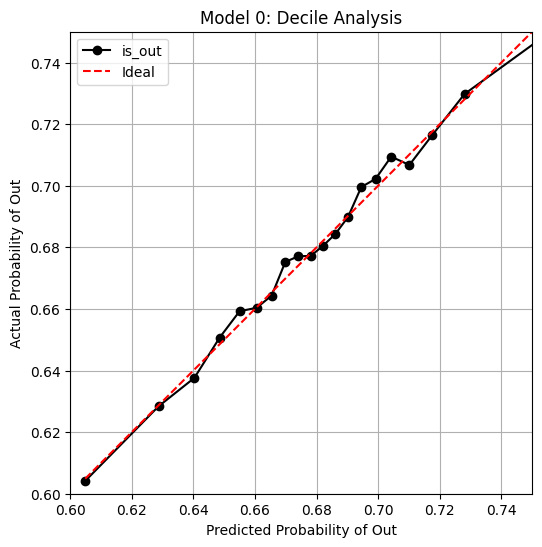

model_0 mean: 0.680009815089955 predicted: 0.6794691243496321 MSE: 8.886423498441915e-06 Integral: 0.5384925721990819




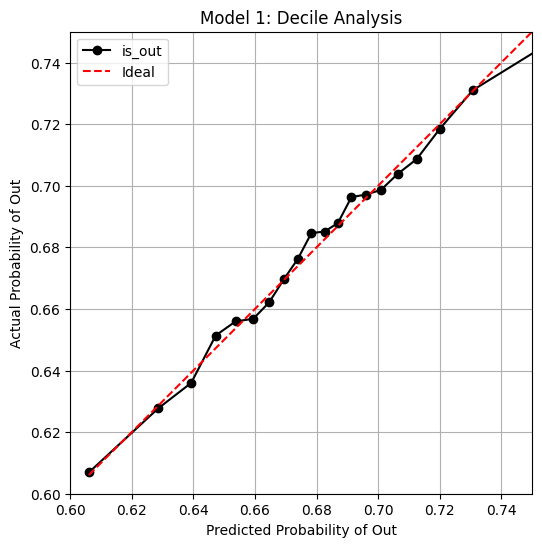

model_1 mean: 0.6800098240478489 predicted: 0.6801308712006755 MSE: 1.167142717008916e-05 Integral: 0.5612945836580708




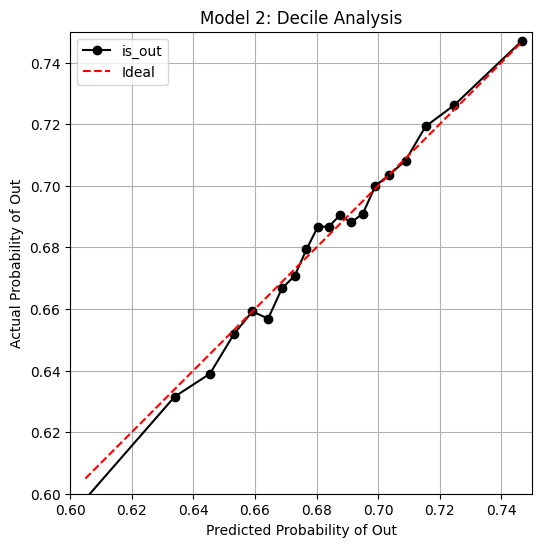

model_2 mean: 0.6800098271831119 predicted: 0.6807907262613158 MSE: 1.3178451977696726e-05 Integral: 0.49668265567775716




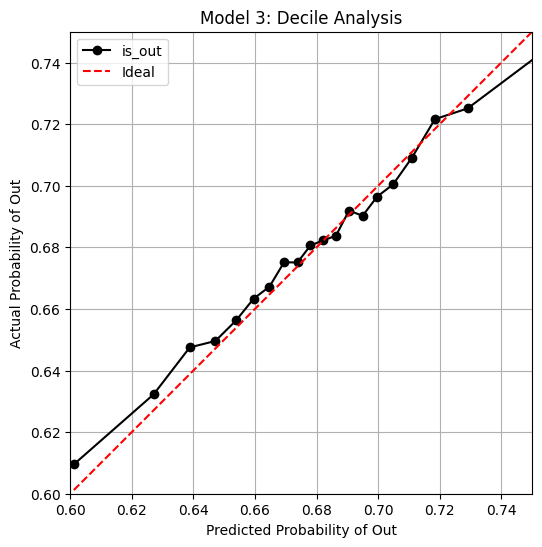

model_3 mean: 0.6800098184491651 predicted: 0.6791646273836809 MSE: 2.155601245334538e-05 Integral: 0.5558291817290424




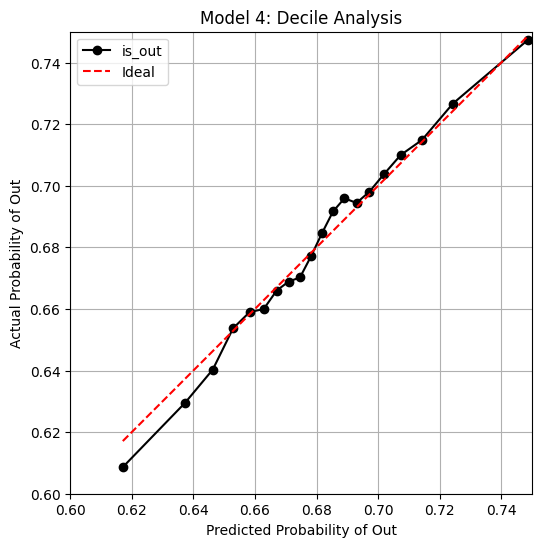

model_4 mean: 0.6800098230027614 predicted: 0.6803947559026985 MSE: 1.5977665036988796e-05 Integral: 0.4769652238830079




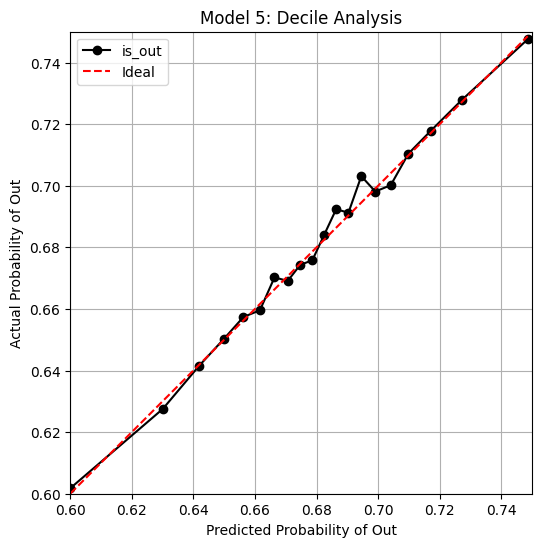

model_5 mean: 0.680009822106972 predicted: 0.6794804349878986 MSE: 8.6193384455165e-06 Integral: 0.5292334613143537




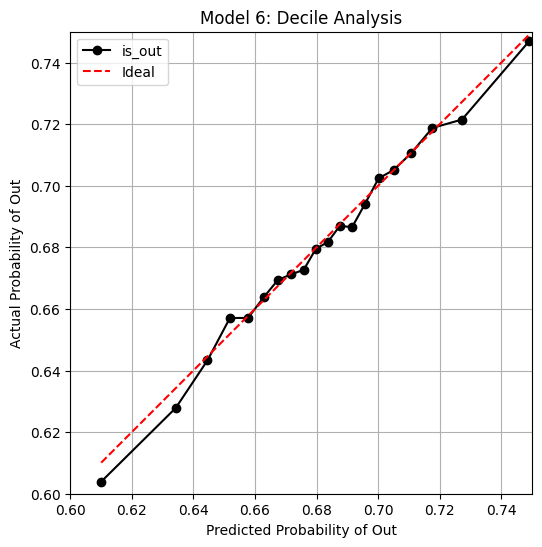

model_6 mean: 0.6800098174787267 predicted: 0.6812180849138966 MSE: 9.954936706552003e-06 Integral: 0.5118092624266556




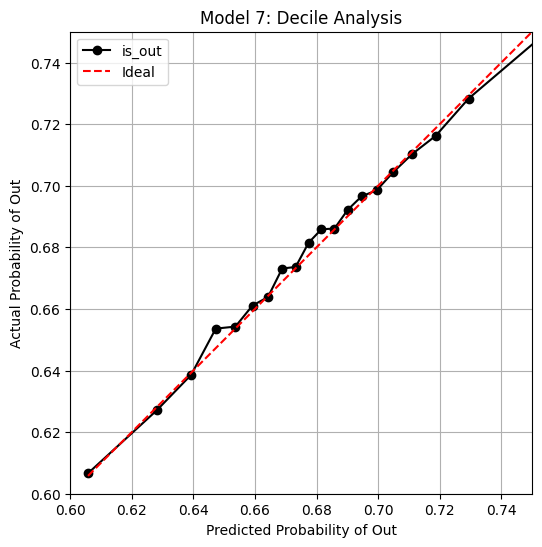

model_7 mean: 0.6800098254661823 predicted: 0.6792841939081503 MSE: 6.91844986868122e-06 Integral: 0.5517362265218108




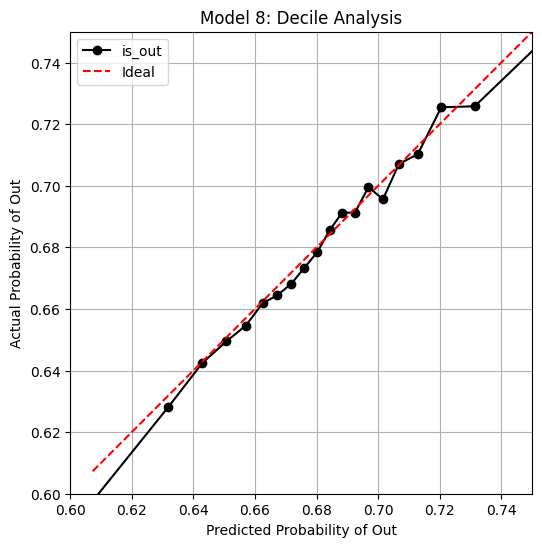

model_8 mean: 0.6800098247196911 predicted: 0.6819527975276857 MSE: 1.5389175812805843e-05 Integral: 0.5435454671485505




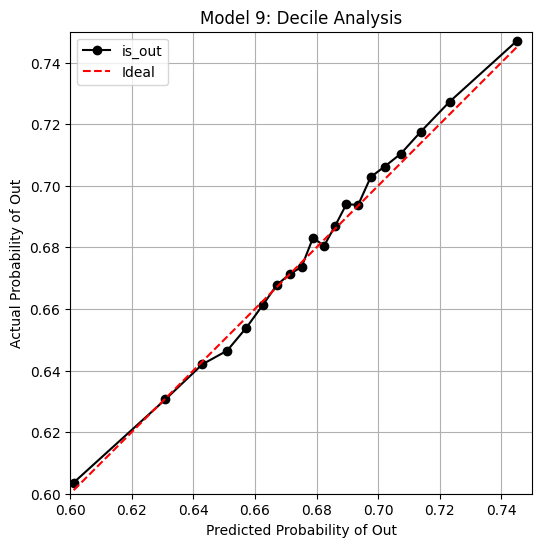

model_9 mean: 0.6800098151646041 predicted: 0.6789429824286071 MSE: 8.589120869202812e-06 Integral: 0.5026506117967197




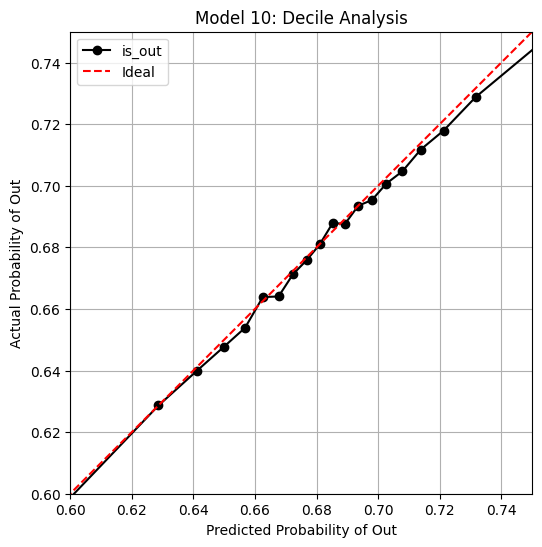

model_10 mean: 0.6800098291986381 predicted: 0.6817220600031464 MSE: 6.764323498651247e-06 Integral: 0.5633859927791137




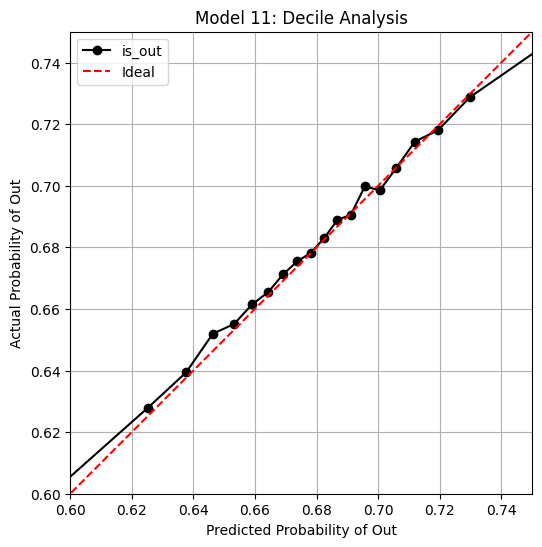

model_11 mean: 0.6800098198674984 predicted: 0.6789583719231974 MSE: 1.0007142099651293e-05 Integral: 0.5751024946765295




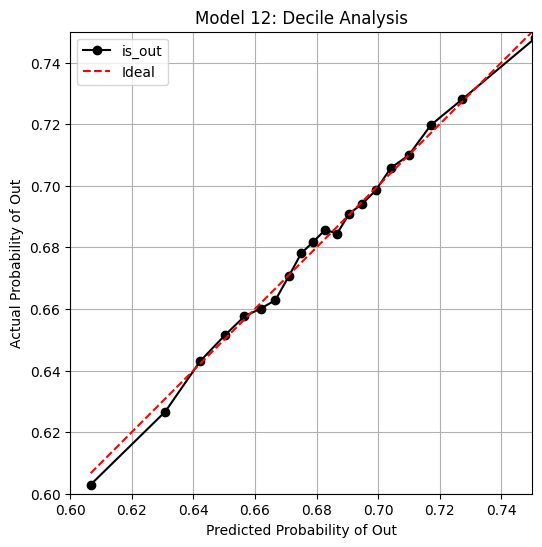

model_12 mean: 0.6800098251675857 predicted: 0.6801842404553737 MSE: 5.177783209456934e-06 Integral: 0.5232200016136577




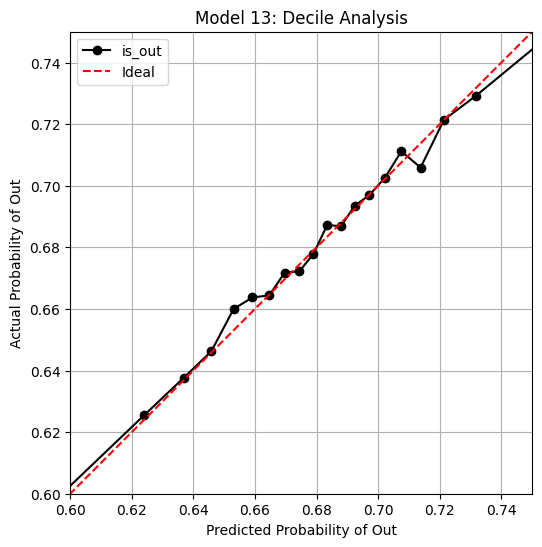

model_13 mean: 0.6800098281535506 predicted: 0.67971230640594 MSE: 1.1682463629363658e-05 Integral: 0.5913824647059104




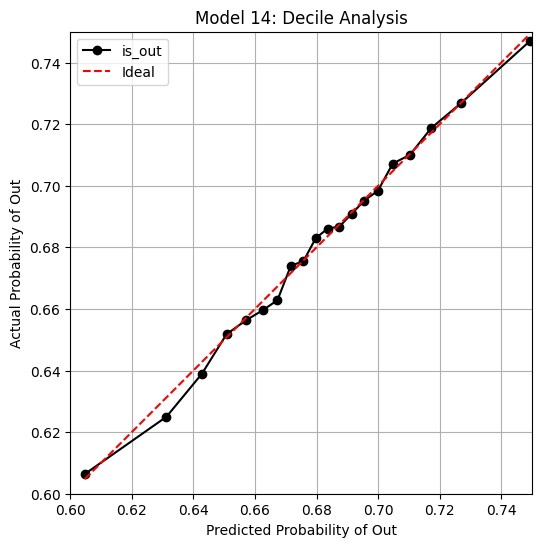

model_14 mean: 0.680009825914077 predicted: 0.6804919090378861 MSE: 6.300360932909383e-06 Integral: 0.5226845549278267




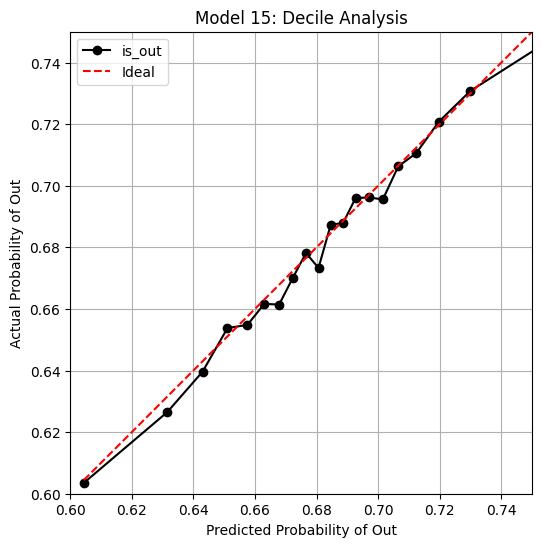

model_15 mean: 0.6800098283774979 predicted: 0.681727367203174 MSE: 1.3888791921709261e-05 Integral: 0.5386542359406572


CPU times: total: 1h 2min 2s
Wall time: 59min 31s


In [42]:
%%time
# List to store model performance stats
model_stats = []
model_list = []

for i in range(number_of_models):
    # Train the model
    model = train_model(i, training_dataset, pa_inputs2, 'eventsModel', layers, activation, alpha, learning_rate, early_stopping, random_state, iters)
    model_list.append(model)
    
    # Predict probabilities
    proba = model.predict_proba(testing_dataset[pa_inputs2].astype(float))
    proba_df = pd.DataFrame(proba, columns=model.classes_)
    testing_dataset[f'model_{i}_is_safe_pred'] = proba_df[['b1', 'b2', 'b3', 'hr', 'bb', 'hbp']].sum(axis=1)
    testing_dataset[f'model_{i}_is_out_pred'] = proba_df[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)

    # Create decile column for current model
    testing_dataset[f'model_{i}_decile'] = pd.qcut(testing_dataset[f'model_{i}_is_out_pred'], 20, labels=False)

    # Group by decile
    df = testing_dataset.groupby(f'model_{i}_decile')[[f'model_{i}_is_out_pred', 'is_out']].mean().reset_index()

    # Calculate projected mean
    pred_mean = df[f'model_{i}_is_out_pred'].mean()
    
    # Calculate actual mean
    act_mean = df['is_out'].mean()
    
    # Calculate mean squared error
    df['error_sq'] = (df[f'model_{i}_is_out_pred'] - df['is_out']) ** 2
    mse = np.mean(df['error_sq'])

    
    # Calculate difference from mean
    df['diff_mean'] = abs(df[f'model_{i}_is_out_pred'] - pred_mean)
    diff_mean = df['diff_mean'].sum()
    

    # Append model stats
    model_stats.append({'model': f'model_{i}', 'index': i, 'mean': act_mean, 'predicted': pred_mean, 'mse': mse, 'diff_mean': diff_mean})
    
                        
    # Graph results
    plt.figure(figsize=(6, 6))  # Make the figure square
    plt.plot(df[f'model_{i}_is_out_pred'], df['is_out'], marker='o', color='black', label='is_out')
    plt.plot(df[f'model_{i}_is_out_pred'], df[f'model_{i}_is_out_pred'], linestyle='--', color='red', label='Ideal')

    # Set limits for both axes
    plt.xlim(.6, .75)
    plt.ylim(.6, .75)

    # Make the aspect ratio equal
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel('Predicted Probability of Out')
    plt.ylabel('Actual Probability of Out')
    plt.title(f'Model {i}: Decile Analysis')
    plt.legend()
    plt.grid()
    plt.show()
                        
    # Print out stats
    print(f"model_{i}", f"mean: {act_mean}", f"predicted: {pred_mean}", f"MSE: {mse}", f"Integral: {diff_mean}")
    print("\n")

### Evaluations

##### Pareto-Optimal Models

In [43]:
pareto_optimal = []
for current in model_stats:
    dominated = False
    for other in model_stats:
        if (
            other['mse'] <= current['mse'] and 
            other['diff_mean'] >= current['diff_mean'] and 
            (other['mse'] < current['mse'] or other['diff_mean'] > current['diff_mean'])
        ):
            dominated = True
            break
    if not dominated:
        pareto_optimal.append(current)

print("\nPareto-optimal models:")
for stats in pareto_optimal:
    print(f"Model: {stats['model']}, Mean: {stats['mean']}, Predicted: {stats['predicted']}, MSE: {stats['mse']}, Diff Mean: {stats['diff_mean']:.4f}")


Pareto-optimal models:
Model: model_10, Mean: 0.6800098291986381, Predicted: 0.6817220600031464, MSE: 6.764323498651247e-06, Diff Mean: 0.5634
Model: model_11, Mean: 0.6800098198674984, Predicted: 0.6789583719231974, MSE: 1.0007142099651293e-05, Diff Mean: 0.5751
Model: model_12, Mean: 0.6800098251675857, Predicted: 0.6801842404553737, MSE: 5.177783209456934e-06, Diff Mean: 0.5232
Model: model_13, Mean: 0.6800098281535506, Predicted: 0.67971230640594, MSE: 1.1682463629363658e-05, Diff Mean: 0.5914


##### Average Results

In [44]:
# 32 - 
mses = []
diff_means = []

for model in model_stats:
    diff_means.append(model['diff_mean'])
    mses.append(model['mse'])
    
print(f"Integral {np.mean(diff_means)}", f"MSE: {np.mean(mses)}")

Integral 0.5364168119374215 MSE: 1.0910116695691383e-05


##### Select Model

In [135]:
selected_index = 8
predict_all = model_list[selected_index]

##### Save

In [136]:
pickle.dump(predict_all, open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'wb'))
all_filename

'predict_all_10_20250119.sav'

##### Output Graphs

Predict outputs

In [137]:
all_outputs = list(predict_all.classes_)
all_outputs_pred = [x + "_pred" for x in all_outputs]

proba = predict_all.predict_proba(testing_dataset[pa_inputs2])
for i, col in enumerate(all_outputs_pred):
    testing_dataset[f'{col}'] = proba[:, i]

Determine quantiles

In [138]:
quantiles = 10
venue_id = 19

for var in all_outputs:
    testing_dataset[f'{var}_act'] = (testing_dataset['eventsModel'] == var).astype('int')
    testing_dataset[f'{var}_decile'] = pd.qcut(testing_dataset[f'{var}_pred'], quantiles, labels=False)
    df_name = var + "_df"
    # Total
    globals()[df_name] = testing_dataset.groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    # # Recent
    # globals()[df_name] = testing_dataset[testing_dataset['year'].astype(int) >= 2022].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    # # Park-specific
    # globals()[df_name] = testing_dataset[testing_dataset['venue_id'].astype(int) == venue_id].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()

Graph

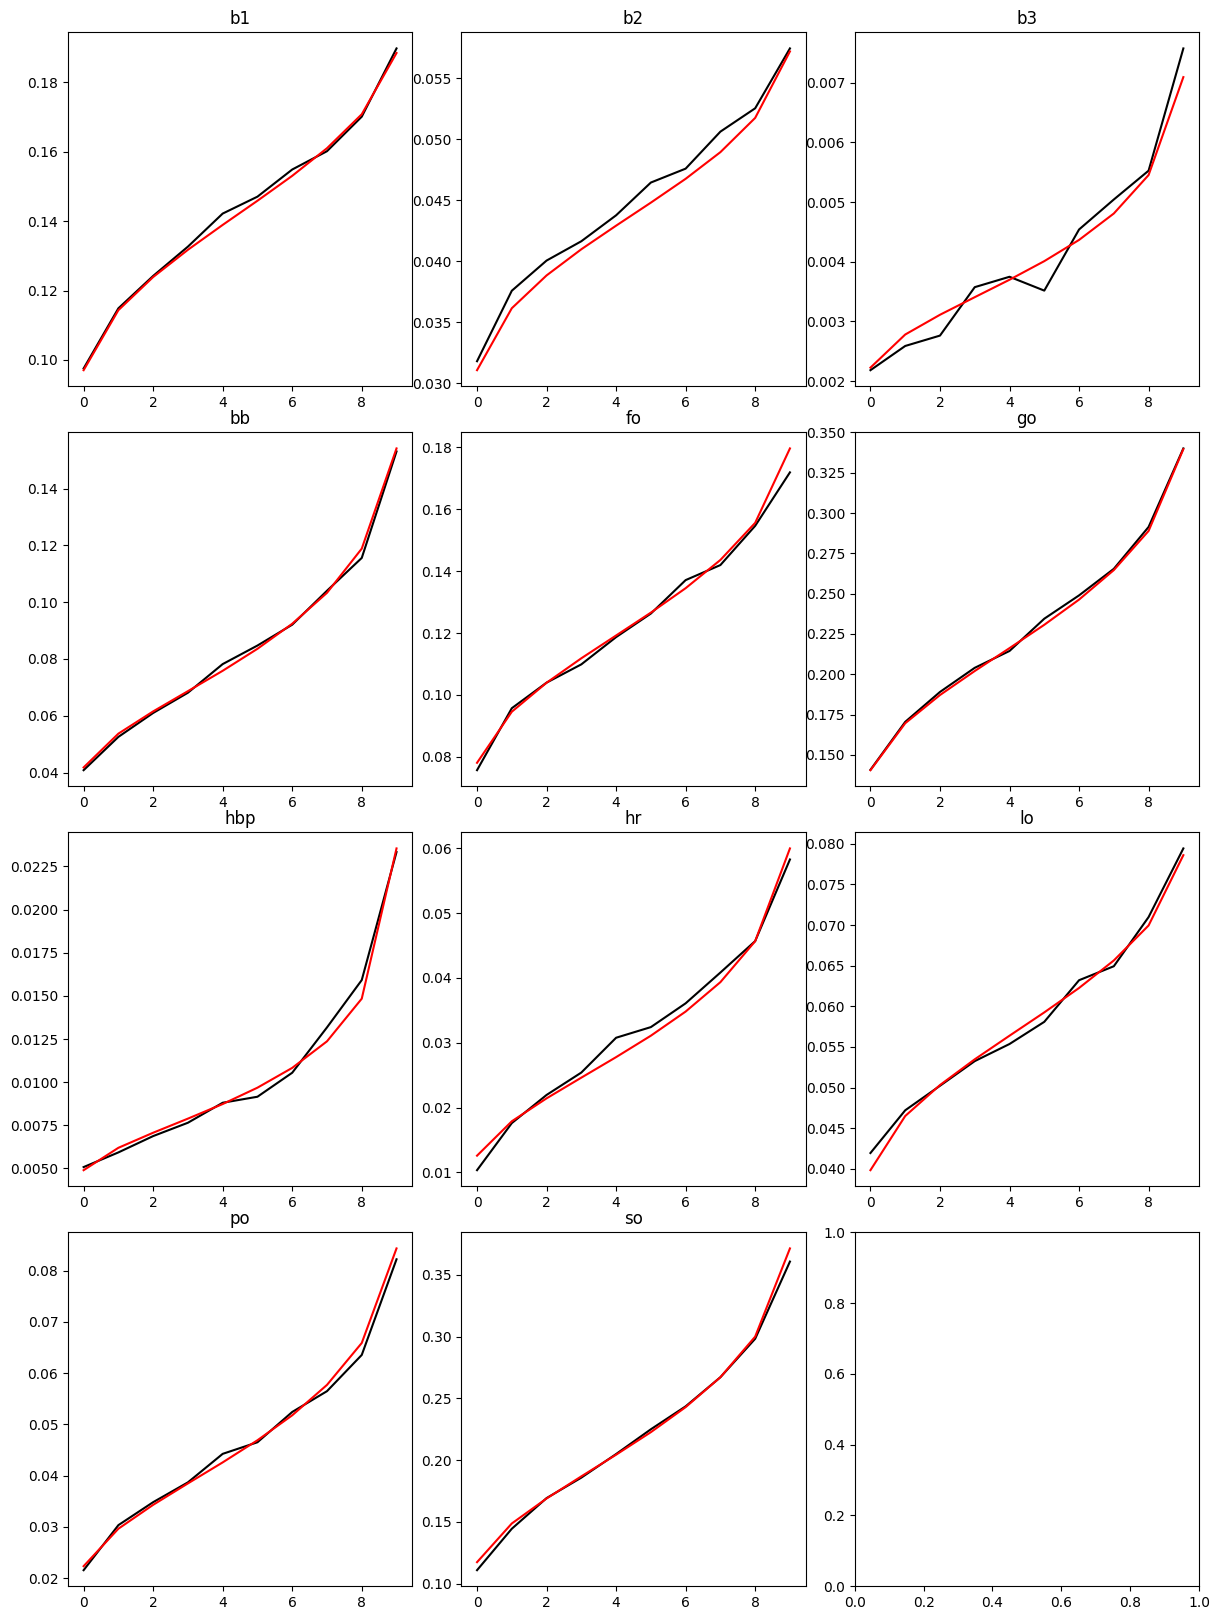

In [139]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

for i, var in enumerate(all_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()